# MedMentions tagging

## Definition

In [10]:

input_data_type = 'lemmatize_nostopwords'
file_date = '2022-11-28_19-41-48'
train_path = f'../results/bertopic/bertopic_{input_data_type}_data_{file_date}_train.csv'
test_path = f'../results/bertopic/bertopic_{input_data_type}_data_{file_date}_test.csv'

results_folder = '../results/bertopic_ncbo/'


In [11]:
UMLS_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HPO', 'ICD10', 'ICD10CM', 'ICD9CM', 'MDR', 'MSH', 'MTH', 'NCBI', 'NCI', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNOMEDCT_US']

# HPO = HP
# MDR = MEDDRA
# MSH = MESH
# MTH = ?
# NCBI = NCBITAXON
# NCI = NCIT
# SNOMEDCT_US = SNMI
UMLS_NCBO_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HP', 'ICD10', 'ICD10CM', 'ICD9CM', 'MEDDRA', 'MESH', 'NCBITAXON', 'NCIT', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNMI']


UMLS_ST21pv_semantic_types_ids = ['T005', 'T007', 'T017', 'T022', 'T031', 'T033', 'T037', 'T038',
'T058', 'T062', 'T074', 'T082', 'T091', 'T092', 'T097', 'T098', 'T103', 'T168', 'T170', 'T201', 'T204']

## Read the data to annotate

In [1]:
def transform_strings_to_arrays(df, col_names = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed', 'tokenized_words_no_stopwords']):
    for col in col_names:
        df[col] = df[col].apply(eval)
    return df

In [2]:
import datetime
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [3]:
import pandas as pd
import re

def read_keywords_extraction_results(path):
    data = pd.read_csv(path, index_col=0)
    data = transform_strings_to_arrays(data, col_names = ['topic_keywords'])
    data['text_to_annotate'] = data.topic_keywords.apply(
        lambda row: re.sub(r"[\'\[\]]", "", str([keyword[0] for keyword in row]))
        )
        
    return data

In [15]:
train_data = read_keywords_extraction_results(train_path)
test_data = read_keywords_extraction_results(test_path)

In [16]:
train_data

,PMID,topic_number,topic_probs,topic_keywords,text_to_annotate
0,25763772,37,0.310848,"[(patient, 0.07), (surgery, 0.013), (treatment...","patient, surgery, treatment, year, outcome, st..."
1,25847295,15,0.046662,"[(cell, 0.053), (expression, 0.023), (gene, 0....","cell, expression, gene, cancer, induced, prote..."
2,26316050,2,0.919338,"[(activity, 0.007), (study, 0.007), (effect, 0...","activity, study, effect, chitosan, movement, m..."
3,26406200,38,0.045627,"[(tumor, 0.028), (case, 0.027), (patient, 0.02...","tumor, case, patient, metastasis, imaging, cli..."
4,26424709,12,0.122145,"[(patient, 0.022), (study, 0.006), (method, 0....","patient, study, method, clinical, result, tech..."
...,...,...,...,...,...
3508,28549399,3,0.063515,"[(muscle, 0.008), (model, 0.005), (study, 0.00...","muscle, model, study, alarm, group, tissue, ex..."
3509,28549760,9,0.120798,"[(study, 0.013), (association, 0.011), (associ...","study, association, associated, risk, BMI, obe..."
3510,28550154,9,0.155204,"[(study, 0.013), (association, 0.011), (associ...","study, association, associated, risk, BMI, obe..."
3511,28550348,37,0.484018,"[(patient, 0.07), (surgery, 0.013), (treatment...","patient, surgery, treatment, year, outcome, st..."


## NCBO tagger API connection

In [4]:
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint

REST_URL = "http://data.bioontology.org"
API_KEY = "194c9635-ce67-4e70-81c5-898c3a2b30fb"

def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

def print_annotations(annotations, get_class=True):
    for result in annotations:
        class_details = result["annotatedClass"]
        if get_class:
            try:
                class_details = get_json(result["annotatedClass"]["links"]["self"])
            except urllib.error.HTTPError:
                print(f"Error retrieving {result['annotatedClass']['@id']}")
                continue
        print("Class details")
        print("\tid: " + class_details["@id"])
        print("\tprefLabel: " + class_details["prefLabel"])
        print("\tontology: " + class_details["links"]["ontology"])

        print("Annotation details")
        for annotation in result["annotations"]:
            print("\tfrom: " + str(annotation["from"]))
            print("\tto: " + str(annotation["to"]))
            print("\tmatch type: " + annotation["matchType"])

        if result["hierarchy"]:
            print("\n\tHierarchy annotations")
            for annotation in result["hierarchy"]:
                try:
                    class_details = get_json(annotation["annotatedClass"]["links"]["self"])
                except urllib.error.HTTPError:
                    print(f"Error retrieving {annotation['annotatedClass']['@id']}")
                    continue
                pref_label = class_details["prefLabel"] or "no label"
                print("\t\tClass details")
                print("\t\t\tid: " + class_details["@id"])
                print("\t\t\tprefLabel: " + class_details["prefLabel"])
                print("\t\t\tontology: " + class_details["links"]["ontology"])
                print("\t\t\tdistance from originally annotated class: " + str(annotation["distance"]))

        print("\n\n")

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions

In [19]:
train_data['ncbo_annotations'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

In [20]:
test_data['ncbo_annotations'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions, but only for sematic types included in ST21pv

In [21]:
train_data['ncbo_annotations_ST21pv_semtypes'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

In [22]:
test_data['ncbo_annotations_ST21pv_semtypes'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

## Save results

In [23]:
now = get_now_str()

save_train_name = f'bertopic_ncbo_{input_data_type}_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo_{input_data_type}_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

to_save_test_data = test_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
to_save_train_data = train_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]

to_save_train_data.to_csv(save_train_path)
to_save_test_data.to_csv(save_test_path)

## Results analysis

In [26]:
train_number_of_ncbo_annotations = train_data['ncbo_annotations'].apply(len)
test_number_of_ncbo_annotations = test_data['ncbo_annotations'].apply(len)
train_number_of_ncbo_annotations_ST21pv_semtypes = train_data['ncbo_annotations_ST21pv_semtypes'].apply(len)
test_number_of_ncbo_annotations_ST21pv_semtypes = test_data['ncbo_annotations_ST21pv_semtypes'].apply(len)

In [27]:
import matplotlib.pyplot as plt

def plot_hist(ax, data, xlab, ylab, title, bins = 10):
    ax.hist(data, bins = bins)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    pass

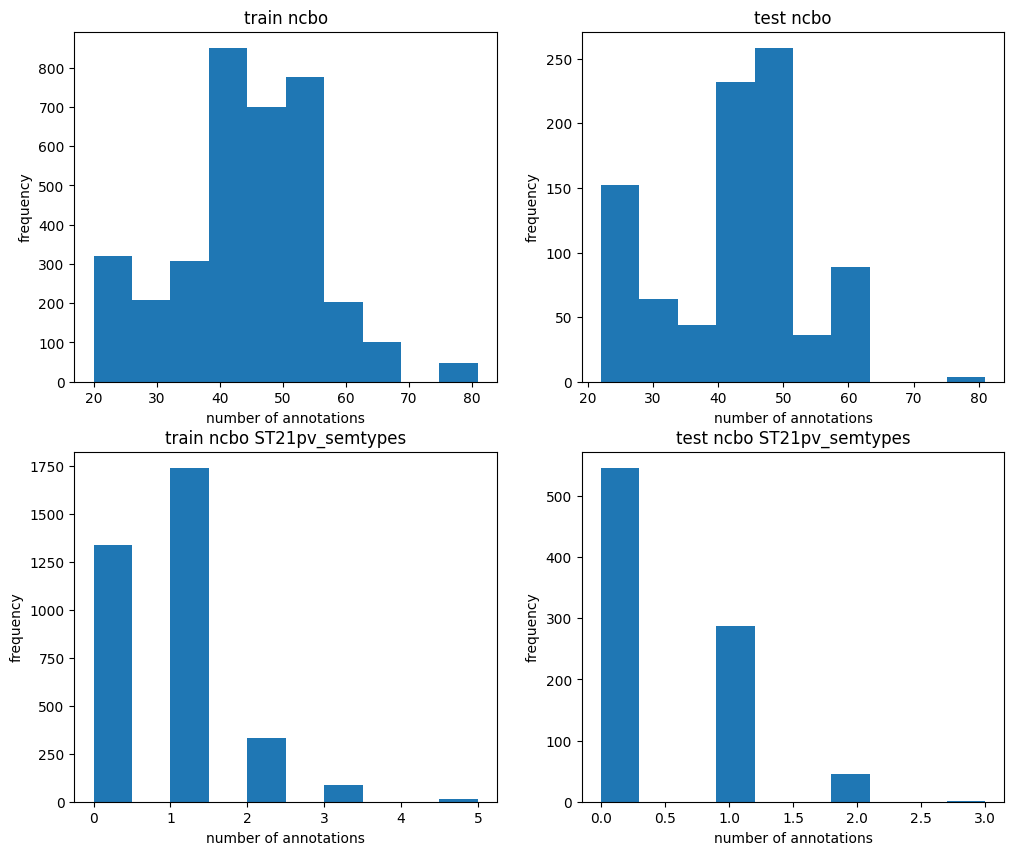

In [28]:
fig, axes = plt.subplots(2,2, figsize=(12, 10))

ax = axes[0,0]
plot_hist(axes[0,0], train_number_of_ncbo_annotations, "number of annotations", "frequency", "train ncbo")
plot_hist(axes[0,1], test_number_of_ncbo_annotations, "number of annotations", "frequency", "test ncbo")
plot_hist(axes[1,0], train_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "train ncbo ST21pv_semtypes")
plot_hist(axes[1,1], test_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "test ncbo ST21pv_semtypes")


## Extracting first order keywords-anotations matching

In [29]:
train_data = pd.read_csv(f'../results/lda_ncbo/lda_ncbo_data_2022-12-07_22-01-04_train.csv', index_col=0)
test_data = pd.read_csv( f'../results/lda_ncbo/lda_ncbo_data_2022-12-07_22-01-04_test.csv', index_col=0)

In [30]:
train_data_to_annotate = train_data[['text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
train_data_to_annotate = train_data_to_annotate.drop_duplicates()

test_data_to_annotate = test_data[['text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
test_data_to_annotate = test_data_to_annotate.drop_duplicates()

In [31]:
data_to_annotate = pd.concat([train_data_to_annotate, test_data_to_annotate], axis=0)
data_to_annotate = data_to_annotate.drop_duplicates()
data_to_annotate = transform_strings_to_arrays(data_to_annotate, col_names=['ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes'])

In [32]:
data_to_annotate.iloc[0]['ncbo_annotations']

[{'annotatedClass': {'@id': 'http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C53691',
   '@type': 'http://www.w3.org/2002/07/owl#Class',
   'links': {'self': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691',
    'ontology': 'https://data.bioontology.org/ontologies/NCIT',
    'children': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/children',
    'parents': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/parents',
    'descendants': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/descendants',
    'ancestors': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/ancestors',
    'instances': 'h

In [10]:
def create_annotation_pairs(sample_row, column_name):
    found_concepts = sample_row[column_name]
    res_ann_pairs= []
    for _, concept in enumerate(found_concepts):
        max_trials = 5
        trials_no = 0
        while trials_no < max_trials:
            try:
                concept_class = get_json(concept["annotatedClass"]["links"]["self"])
                concept_class_ancestors = get_json(concept["annotatedClass"]['links']['ancestors'])
                break
            except:
                trials_no+=1
                continue
        if trials_no==max_trials:
            raise Exception("number of unsuccessfull connection attempts is max_trials")

        annotations = concept['annotations']

        # annotations for this class
        for annot in annotations:
            res_ann_pairs.append([annot['text'], concept_class["prefLabel"], 'DIRECT', concept["annotatedClass"]["links"]["self"]])

        # annotations for ancestors
        for annot in annotations:
            for ancestor in concept_class_ancestors:
                res_ann_pairs.append([annot['text'], ancestor["prefLabel"], 'ANCESTOR', concept["annotatedClass"]['links']['ancestors']])
      
    unique_ann_pairs = [list(x) for x in set(tuple(x) for x in res_ann_pairs)]
    return unique_ann_pairs
        

In [34]:
data_to_annotate['ncbo_annotation_pairs'] = data_to_annotate.apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)

In [35]:
data_to_annotate['ncbo_annotation_ST21pv_semtypes_pairs'] = data_to_annotate.apply(create_annotation_pairs, column_name='ncbo_annotations_ST21pv_semtypes', axis = 1)

### Annotation pairs example

In [36]:
data_to_annotate['ncbo_annotation_pairs'].iloc[0]

[['TREATMENT',
  'Complementary or Alternative Medical Procedure',
  'DIRECT',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C51976'],
 ['CANCER',
  'Decapoda',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCBITAXON/classes/http%3A%2F%2Fpurl.bioontology.org%2Fontology%2FNCBITAXON%2F6754/ancestors'],
 ['YEAR',
  'Unit by Category',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C29848/ancestors'],
 ['GROUP',
  'Group',
  'DIRECT',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C43359'],
 ['RATE',
  'Characteristic',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C25636/ancestors'],
 ['GROUP',
  'Stage Grouping',
  'DIRECT',
  'https://data.bioontol

In [37]:
data_to_annotate[['text_to_annotate', 'ncbo_annotation_pairs']].to_dict()

{'text_to_annotate': {0: 'patient, surgery, treatment, year, outcome, study, group, cancer, P, rate',
  1: 'cell, expression, gene, cancer, induced, protein, role, mouse, pathway, level',
  2: 'activity, study, effect, chitosan, movement, migraine, safety, rotor, risk, resistance',
  3: 'tumor, case, patient, metastasis, imaging, clinical, rare, carcinoma, diagnosis, report',
  4: 'patient, study, method, clinical, result, technique, pain, disease, analysis, image',
  5: 'study, function, rate, effect, warning, mild, control, collagen, insulin, result',
  6: 'study, group, symptom, disorder, patient, associated, low, compared, thickness, risk',
  7: 'patient, study, group, effect, disease, level, treatment, trait, risk, adult',
  8: 'delivery, method, study, cerclage, showed, woman, analysis, functional, feature, total',
  9: 'risk, 95, patient, study, factor, associated, polymorphism, level, disease, population',
  11: 'disease, response, forest, plant, study, result, 2, target, patie

## Save annotated pairs

In [38]:
text_to_annot_ncbo_pairs = dict(zip(data_to_annotate.text_to_annotate, data_to_annotate.ncbo_annotation_pairs))
text_to_annot_ncboST21pv_semtypes_pairs = dict(zip(data_to_annotate.text_to_annotate, data_to_annotate.ncbo_annotation_ST21pv_semtypes_pairs))

In [39]:
train_data['ncbo_annotations_pairs'] = train_data['text_to_annotate'].apply(lambda text: text_to_annot_ncbo_pairs[text])
train_data['ncbo_annotations_ST21pv_semtypes_pairs'] = train_data['text_to_annotate'].apply(lambda text: text_to_annot_ncboST21pv_semtypes_pairs[text])

test_data['ncbo_annotations_pairs'] = test_data['text_to_annotate'].apply(lambda text: text_to_annot_ncbo_pairs[text])
test_data['ncbo_annotations_ST21pv_semtypes_pairs'] = test_data['text_to_annotate'].apply(lambda text: text_to_annot_ncboST21pv_semtypes_pairs[text])

In [40]:
test_data

,PMID,text_to_annotate,ncbo_annotations,ncbo_annotations_ST21pv_semtypes,ncbo_annotations_pairs,ncbo_annotations_ST21pv_semtypes_pairs
0,26868132,"risk, 95, patient, study, factor, associated, ...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[FACTOR, Feelings about Genomic Testing Resul...","[[POPULATION, Population, DIRECT, https://data..."
1,27059693,"disease, response, forest, plant, study, resul...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[FOOD, Physical Object, ANCESTOR, https://dat...","[[FOOD, Food and Beverages, ANCESTOR, https://..."
2,27061776,"study, patient, associated, data, condition, s...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[CONDITION, Property or Attribute, ANCESTOR, ...","[[DATA, Mandibulata, ANCESTOR, https://data.bi..."
3,27172917,"muscle, model, study, alarm, group, tissue, ex...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[EXERCISE, Intervention or Procedure, ANCESTO...",[]
4,27213687,"study, patient, associated, data, condition, s...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[CONDITION, Property or Attribute, ANCESTOR, ...","[[DATA, Mandibulata, ANCESTOR, https://data.bi..."
...,...,...,...,...,...,...
874,28548970,"muscle, model, study, alarm, group, tissue, ex...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[EXERCISE, Intervention or Procedure, ANCESTO...",[]
875,28549352,"TB, DNA, resistance, study, methylation, group...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[],"[[STAGE, Phase, DIRECT, https://data.bioontolo...",[]
876,28549770,"acid, event, P, group, treatment, study, day, ...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[TREATMENT, Complementary or Alternative Medi...","[[ACID, Inorganic Chemicals, ANCESTOR, https:/..."
877,28550165,"TB, DNA, resistance, study, methylation, group...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[],"[[STAGE, Phase, DIRECT, https://data.bioontolo...",[]


In [41]:
train_data

,PMID,text_to_annotate,ncbo_annotations,ncbo_annotations_ST21pv_semtypes,ncbo_annotations_pairs,ncbo_annotations_ST21pv_semtypes_pairs
0,25763772,"patient, surgery, treatment, year, outcome, st...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[TREATMENT, Complementary or Alternative Medi...","[[CANCER, Brachyura, ANCESTOR, https://data.bi..."
1,25847295,"cell, expression, gene, cancer, induced, prote...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[CELL, Entity, ANCESTOR, https://data.bioonto...","[[CANCER, Brachyura, ANCESTOR, https://data.bi..."
2,26316050,"activity, study, effect, chitosan, movement, m...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[],"[[MIGRAINE, Headache, ANCESTOR, https://data.b...",[]
3,26406200,"tumor, case, patient, metastasis, imaging, cli...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[CLINICAL, Clinical, DIRECT, https://data.bio...","[[DIAGNOSIS, Diagnosis, DIRECT, https://data.b..."
4,26424709,"patient, study, method, clinical, result, tech...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CLINICAL, Clinical, DIRECT, https://data.bio...",[]
...,...,...,...,...,...,...
3508,28549399,"muscle, model, study, alarm, group, tissue, ex...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[EXERCISE, Intervention or Procedure, ANCESTO...",[]
3509,28549760,"study, association, associated, risk, BMI, obe...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[OBESITY, Increased body weight, ANCESTOR, ht...","[[WEIGHT, Physical examination procedures and ..."
3510,28550154,"study, association, associated, risk, BMI, obe...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[OBESITY, Increased body weight, ANCESTOR, ht...","[[WEIGHT, Physical examination procedures and ..."
3511,28550348,"patient, surgery, treatment, year, outcome, st...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[TREATMENT, Complementary or Alternative Medi...","[[CANCER, Brachyura, ANCESTOR, https://data.bi..."


In [42]:
now = get_now_str()

# save_train_name = f'bertopic_ncbo_fulldata_{input_data_type}_data_{now}_train.csv'
# save_test_name = f'bertopic_ncbo__fulldata_{input_data_type}_data_{now}_test.csv'

save_train_name = f'bertopic_ncbo_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

In [43]:
train_data.to_csv(save_train_path, index=False)
test_data.to_csv(save_test_path, index=False)

#

# CRAFT tagging

In [11]:
# read data from extracted keywrods
keywords_extractor = 'bertopic'
keywords_extr_path = f'../results/{keywords_extractor}/{keywords_extractor}_lemmatize_nostopwords_data_2023-01-04_17-50-52.csv'
results_folder ='../results'


# read data
data = read_keywords_extraction_results(keywords_extr_path)

# annotate data
CRAFT_ONTOLOGIES = ['CHEBI', 'CL', 'GO', 'MONDO', 'MOP', 'NCBITAXON', 'PR', 'SO', 'UBERON']
data['ncbo_annotations'] \
     = data.text_to_annotate.apply(lambda text:  \
        get_json(REST_URL + f"/annotator?ontologies={','.join(CRAFT_ONTOLOGIES)}&text=" + urllib.parse.quote(text)))

data = data[['PMID', 'text_to_annotate', 'ncbo_annotations']]

data_to_annotate = data[['text_to_annotate', 'ncbo_annotations']]
data_to_annotate = data_to_annotate.loc[data_to_annotate.astype(str).drop_duplicates().index]
data_to_annotate['ncbo_annotation_pairs'] = data_to_annotate.apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)

# create annotation pairs
data_to_annotate[['text_to_annotate', 'ncbo_annotation_pairs']].to_dict()
text_to_annot_ncbo_pairs = dict(zip(data_to_annotate.text_to_annotate, data_to_annotate.ncbo_annotation_pairs))
data['ncbo_annotations_pairs'] = data['text_to_annotate'].apply(lambda text: text_to_annot_ncbo_pairs[text])

# save data
now = get_now_str()
save_name = f'../results/{keywords_extractor}_ncbo/{keywords_extractor}_ncbo_data_{now}.csv'
data.to_csv(save_name, index=False)

In [7]:
data_to_annotate

,text_to_annotate,ncbo_annotations
0,"olfactory, receptor, dopamine, d2, taste, volu...",[{'annotatedClass': {'@id': 'http://purl.bioon...
1,"mouse, strain, background, muscle, phenotype, ...",[{'annotatedClass': {'@id': 'http://purl.oboli...
2,"gene, mouse, expression, cell, protein, develo...",[{'annotatedClass': {'@id': 'http://purl.oboli...
3,"gene, mouse, expression, cell, protein, develo...",[{'annotatedClass': {'@id': 'http://purl.oboli...
4,"mouse, protein, gene, pax6, differentiation, p...",[{'annotatedClass': {'@id': 'http://purl.oboli...
...,...,...
92,"mouse, strain, background, muscle, phenotype, ...",[{'annotatedClass': {'@id': 'http://purl.oboli...
93,"mouse, protein, gene, pax6, differentiation, p...",[{'annotatedClass': {'@id': 'http://purl.oboli...
94,"mouse, protein, gene, pax6, differentiation, p...",[{'annotatedClass': {'@id': 'http://purl.oboli...
95,"mouse, protein, gene, pax6, differentiation, p...",[{'annotatedClass': {'@id': 'http://purl.oboli...
